### Import the library 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians
# import pymc3 as pm

### Import the data

In [12]:
df = pd.read_csv("nyc-taxi-trip-duration/train.csv")
display(df.shape)
df.head()

(1458644, 11)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [35]:
wall_street_location = [40.70729,-74.01095]
sample_location = [[40.73,-74.05],[40.665,-73.795],[40.77,-73.995],[40.74,-73.99],[40.695,-73.95],[40.767,-73.875]]

In [13]:
def get_distance_between_points(lat1,lon1,lat2,lon2):
    '''
    This function is used to get the distance between lat1, lon1 and lat2, lon2
    '''
    # approximate radius of earth in km
    R = 6378.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [17]:
# calculate the distance between the location of wall street to others point in the dataset.
df['dist_pickup_to_wall_street'] = np.vectorize(get_distance_between_points)(wall_street_location[0],wall_street_location[1],df['pickup_latitude'], df['pickup_longitude'])



In order to extract the most relevant information from the
dataset for our purpose, we create a filtered dataset, in
which either the pick-up or drop-off location lies within
500 m from Wall Street (indicated by the red oval in Fig.
3(b)). In addition, we filter trips with unrealistically long
durations (>20 000 s).

In [25]:
df_wall = df[( df['dist_pickup_to_wall_street'] <= 0.5)& (df['trip_duration'] < 20000)]
df_wall.shape



(20535, 13)

### Choosing the prediction model

simply use 5 different prediction algorithm as the model, and compare its performance.

From this data, we will only use its location (dropoff_longitude and dropoff_latitude) and distance from the HQ to predict the trip duration.

In [31]:
 
temp_df = df_wall[['dropoff_latitude','dropoff_longitude','dist_pickup_to_dropoff','trip_duration']].copy()

# Declare the model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split
experiments = {"Algorithm":["Ordinary Least Squares", "Regression Tree", 
                            "Big Random Forest", "Random Forest", 
                            "Bagging"], 
               "Objects" : [lambda : LinearRegression(), 
                            lambda : DecisionTreeRegressor(), 
                            lambda : RandomForestRegressor(n_estimators=100), 
                            lambda : RandomForestRegressor(), 
                            lambda : BaggingRegressor()], 
               "Predictions":[[] for _ in range(5)]}
actuals = []

In [32]:
# run the 5 differenet algorithm and compare the result

for _ in range (4):
    train_X, test_X, train_y, test_y = (
        train_test_split(temp_df.drop("trip_duration", axis=1), 
                         temp_df["trip_duration"], test_size=0.33))
    for i, obj_factory in enumerate(experiments["Objects"]):
        obj = obj_factory()
        obj.fit(y=train_y,X=train_X)
        experiments["Predictions"][i] += list(obj.predict(test_X))
    actuals += list(test_y)
actuals = pd.Series(actuals)
experiments["Predictions"] = list(map(pd.Series, experiments["Predictions"]))

# Get the performance of every model
experiments["Results"] = []
for o in experiments["Objects"]:
    experiments["Results"].append(
        model_selection.cross_val_score(o(), y=temp_df['trip_duration'], 
                                        X=temp_df.drop("trip_duration", axis=1),
                                        cv=5).mean())

pd.DataFrame(experiments).drop(["Objects", "Predictions"], 
                            axis=1).set_index("Algorithm")

/Users/lilianaester/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lilianaester/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lilianaester/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lilianaester/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lilianaes

,Results
Algorithm,
Ordinary Least Squares,0.514720
Regression Tree,0.175229
Big Random Forest,0.530753
Random Forest,0.495073
Bagging,0.497449


Big random forest performance very well compare to the other. So, in this case, we will use big random forest as the algorithm for predicting trip duration. To easily re-produce the model, it is important to create the model in a function.

In [37]:
def create_model(temp_df, wall_street_location):
    '''
    parameter : 
        - temp_df = the training dataframe
        - wall_street_location = the headquarter
    '''
    train_X, test_X, train_y, test_y = ( train_test_split(temp_df.drop("trip_duration", axis=1), 
                             temp_df["trip_duration"], test_size=0.33))

    obj = RandomForestRegressor(n_estimators=100)
    obj.fit(y=train_y,X=train_X)
    obj.predict(test_X)
    
    print("Cross val score : ",model_selection.cross_val_score(obj, y=temp_df['trip_duration'], 
                                            X=temp_df.drop("trip_duration", axis=1),
                                            cv=5).mean())
    obj.predict(temp_df.drop("trip_duration", axis=1))

    ## CREATE THE SAMPLE FOR THE MODEL
    sample_lat = []
    for i in range(40):
        sample_lat.append(i*0.01 + 40.5)

    sample_lng = []
    for i in range(60):
        sample_lng.append(i*0.01 -74.3)
        
    temp2_list = []
    tempi_list = []
    tempj_list = []
    tempdist_list = []
    for i in sample_lat:
        temp1_list = []
        for j in sample_lng:
            tempi_list.append(i)
            tempj_list.append(j)
            tempdist_list.append(get_distance_between_points(wall_street_location[0],wall_street_location[1],i,j))

    d = {'dropoff_latitude' : tempi_list,
     'dropoff_longitude' : tempj_list,
    'dist_pickup_to_dropoff': tempdist_list}
    temp_pred_df = pd.DataFrame(d)  
    
    temp_pred_df['predicted_dist'] = obj.predict(temp_pred_df)
    return temp_pred_df

In [34]:
xdf = create_model(temp_df,wall_street_location)

Cross val score :  0.530246231144532


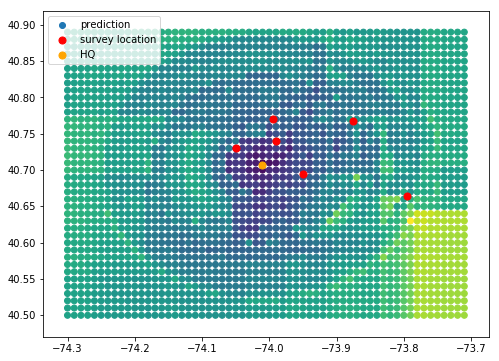

In [42]:
x,y = zip(*sample_location)
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x=xdf['dropoff_longitude'],y= xdf['dropoff_latitude'], c=xdf['predicted_dist'],label = 'prediction')
ax1.scatter(y,x, s=50, c='r', marker="o", label='survey location')
ax1.scatter(wall_street_location[1],wall_street_location[0], s=50, c='orange', marker="o", label='HQ')
plt.legend(loc='upper left');
plt.show()